<a href="https://colab.research.google.com/github/chejuro/ImgCap/blob/main/ImgCap_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ipdb -q

     |████████████████████████████████| 788kB 8.0MB/s 
     |████████████████████████████████| 368kB 58.5MB/s 
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.19 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.25.0 which is incompatible.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import os
import cv2
import json
from zipfile import ZipFile
import pickle
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm, trange
from copy import deepcopy
from collections import defaultdict, Counter
from sklearn.metrics import confusion_matrix

import re

%matplotlib inline
%load_ext tensorboard

In [4]:
def copy_file(filename, path_from, path_to):
    os.system(f"cp '{path_from+filename}' {path_to}")

    print(os.listdir())

def copy_zipfile(zip_file, path_from, path_to):
    os.system(f"cp '{path_from+zip_file}' {path_to}")
    z = ZipFile(zip_file, 'r')
    z.extractall()

    print(os.listdir())


def get_annotations(zipfile, annotation_file):
    zf = ZipFile(zipfile)
    j = json.loads(zf.read(f"annotations/{annotation_file}").decode("utf8"))

    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)

    df = pd.DataFrame([fn_to_caps])
    df = df.T.reset_index()
    df.columns = ['image', 'captions']

    return df

In [ ]:
%%time

copy_zipfile("train2014.zip", 
             "/content/drive/MyDrive/pet projects/image cap/data/", 
             "/content/")

copy_zipfile("val2014.zip", 
             "/content/drive/MyDrive/pet projects/image cap/data/", 
             "/content/")

copy_zipfile("captions_train-val2014.zip", 
             "/content/drive/MyDrive/pet projects/image cap/data/", 
             "/content/")

['.config', 'drive', 'train2014.zip', 'train2014', 'sample_data']
['.config', 'val2014.zip', 'val2014', 'drive', 'train2014.zip', 'train2014', 'sample_data']
['.config', 'val2014.zip', 'val2014', 'drive', 'train2014.zip', 'train2014', 'captions_train-val2014.zip', 'annotations', 'sample_data']
CPU times: user 1min 8s, sys: 49.2 s, total: 1min 57s
Wall time: 13min 27s


In [ ]:
train_df = get_annotations('captions_train-val2014.zip', 
                           'captions_train2014.json')

valid_df = get_annotations('captions_train-val2014.zip', 
                           'captions_val2014.json')

train_df.to_pickle('train.pkl')
valid_df.to_pickle('valid.pkl')

train_df.head()

,image,captions
0,COCO_train2014_000000318556.jpg,[A very clean and well decorated empty bathroo...
1,COCO_train2014_000000116100.jpg,[A panoramic view of a kitchen and all of its ...
2,COCO_train2014_000000379340.jpg,[A graffiti-ed stop sign across the street fro...
3,COCO_train2014_000000134754.jpg,"[The two people are walking down the beach., T..."
4,COCO_train2014_000000538480.jpg,"[A sink and a toilet inside a small bathroom.,..."


In [ ]:
train_df.shape, valid_df.shape

((82783, 2), (40504, 2))

# Dataset

In [ ]:
class DatasetImgCap(Dataset):
    def __init__(self, data_path, root_dir, input_shape=(224, 224), transform=None):
        self.df_data = pd.read_pickle(data_path)
        self.root_dir = root_dir
        self.input_shape = input_shape
        self.transform = transform

    def __len__(self):
        return len(self.df_data)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        img_name = os.path.join(self.root_dir,
                                str(self.df_data.iloc[index, 0]))
        image = cv2.imread(img_name)
        image = self.image_center_crop(image)
        image = cv2.resize(image, self.input_shape)
        image = np.transpose(image, (2, 0, 1))
        image = (image / 255.).astype(np.float32)

        assert image.shape == (3, self.input_shape[0], self.input_shape[1])

        captions = self.df_data.iloc[index, 1]
        if self.transform:
            image = self.transform(image)

        return image, captions


    def image_center_crop(self, img):
        h, w = img.shape[0], img.shape[1]
        pad_left = 0
        pad_right = 0
        pad_top = 0
        pad_bottom = 0
        if h > w:
            diff = h - w
            pad_top = diff - diff // 2
            pad_bottom = diff // 2
        else:
            diff = w - h
            pad_left = diff - diff // 2
            pad_right = diff // 2
        return img[pad_top:h-pad_bottom, pad_left:w-pad_right, :]

In [ ]:
IMG_SIZE = 299
dataset = DatasetImgCap('train.pkl', 'train2014/', input_shape=(IMG_SIZE, IMG_SIZE))
len(dataset)

82783

Label: ['A very clean and well decorated empty bathroom', 'A blue and white bathroom with butterfly themed wall tiles.', 'A bathroom with a border of butterflies and blue paint on the walls above it.', 'An angled view of a beautifully decorated bathroom.', 'A clock that blends in with the wall hangs in a bathroom. ']


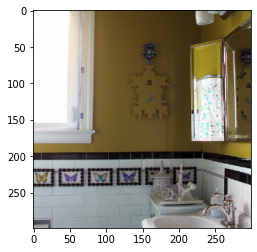

In [ ]:
img, captions = dataset[0]
print("Label:", captions)

plt.imshow(np.transpose(img, (1, 2, 0)))
# plt.imshow(img)
plt.show()

Label: ['A panoramic view of a kitchen and all of its appliances.', 'A panoramic photo of a kitchen and dining room', 'A wide angle view of the kitchen work area', 'multiple photos of a brown and white kitchen. ', 'A kitchen that has a checkered patterned floor and white cabinets.']


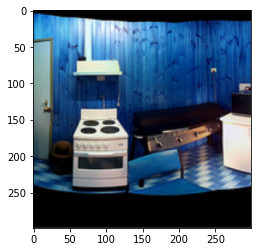

In [ ]:
img, captions = dataset[1]
print("Label:", captions)

plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

# Image embeds

### Calculate image embeds (you can skip this stage if you already have image embeds)

In [ ]:
backbone = models.inception_v3(pretrained=True)
backbone.fc = nn.Identity()
backbone = backbone.eval()

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    backbone = backbone.to(device)

In [ ]:
def calc_embeds(dataset, backbone):
    embeds = []

    with torch.no_grad():
        for i in trange(len(dataset)):
            img, _ = dataset[i]
            embed = backbone(torch.Tensor(img[None, ...]).to(device))
            embed = embed.cpu().numpy().ravel()
            embeds.append(embed)
    
    return np.array(embeds)

In [ ]:
train_dataset = DatasetImgCap('train.pkl', 'train2014/', input_shape=(IMG_SIZE, IMG_SIZE))
train_embeds = calc_embeds(train_dataset, backbone)

In [ ]:
valid_dataset = DatasetImgCap('valid.pkl', 'val2014/', input_shape=(IMG_SIZE, IMG_SIZE))
valid_embeds = calc_embeds(valid_dataset, backbone)

### Load embeds

In [ ]:
# with open('/content/drive/MyDrive/pet projects/image cap/data/train_image_embeds.pkl','wb') as f:
#     pickle.dump(train_embeds, f)

# with open('/content/drive/MyDrive/pet projects/image cap/data/valid_image_embeds.pkl','wb') as f:
#     pickle.dump(valid_embeds, f)

In [ ]:
train_embeds = np.load('/content/drive/MyDrive/pet projects/image cap/data/train_image_embeds.pkl', 
                       allow_pickle=True)
valid_embeds = np.load('/content/drive/MyDrive/pet projects/image cap/data/valid_image_embeds.pkl', 
                       allow_pickle=True)

In [ ]:
train_embeds.shape, valid_embeds.shape

((82783, 2048), (40504, 2048))

# Prepare captions for training

In [5]:
train_embeds = np.load('/content/drive/MyDrive/pet projects/image cap/data/train_image_embeds.pkl', 
                       allow_pickle=True)
valid_embeds = np.load('/content/drive/MyDrive/pet projects/image cap/data/valid_image_embeds.pkl', 
                       allow_pickle=True)

copy_file("train_image_embeds.pkl", 
          "/content/drive/MyDrive/pet projects/image cap/data/", 
          "/content/")
copy_file("valid_image_embeds.pkl",
          "/content/drive/MyDrive/pet projects/image cap/data/", 
          "/content/")

copy_file("train.pkl", 
          "/content/drive/MyDrive/pet projects/image cap/data/", 
          "/content/")
copy_file("valid.pkl",
          "/content/drive/MyDrive/pet projects/image cap/data/", 
          "/content/")

train_df = pd.read_pickle('train.pkl')
valid_df = pd.read_pickle('valid.pkl')

['.config', 'drive', 'train_image_embeds.pkl', 'sample_data']
['.config', 'drive', 'train_image_embeds.pkl', 'valid_image_embeds.pkl', 'sample_data']
['.config', 'drive', 'train_image_embeds.pkl', 'valid_image_embeds.pkl', 'train.pkl', 'sample_data']
['.config', 'drive', 'train_image_embeds.pkl', 'valid_image_embeds.pkl', 'valid.pkl', 'train.pkl', 'sample_data']


In [6]:
train_captions = train_df['captions'].values.tolist()
val_captions = valid_df['captions'].values.tolist()
len(train_captions), len(val_captions)

(82783, 40504)

In [7]:
train_captions[:2]

[['A very clean and well decorated empty bathroom',
  'A blue and white bathroom with butterfly themed wall tiles.',
  'A bathroom with a border of butterflies and blue paint on the walls above it.',
  'An angled view of a beautifully decorated bathroom.',
  'A clock that blends in with the wall hangs in a bathroom. '],
 ['A panoramic view of a kitchen and all of its appliances.',
  'A panoramic photo of a kitchen and dining room',
  'A wide angle view of the kitchen work area',
  'multiple photos of a brown and white kitchen. ',
  'A kitchen that has a checkered patterned floor and white cabinets.']]

In [8]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Use `split_sentence` function to split sentence into tokens.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    all_tokens = []

    for sentences in train_captions:
        for s in sentences:
            tokens = split_sentence(s)
            all_tokens.extend(tokens)

    all_tokens = Counter(all_tokens)
    all_tokens_filtered = {k: v for (k,v) in all_tokens.items() if v >= 5}
    vocab = dict(zip(all_tokens_filtered.keys(), range(len(all_tokens_filtered))))
    N = len(all_tokens_filtered)
    vocab[PAD] = N + 1
    vocab[UNK] = N + 2
    vocab[START] = N + 3
    vocab[END] = N + 4

    return {token: index for index, token in enumerate(sorted(vocab))}
    
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    res = []
    for sentences in captions:
        sentence_tokens = []
        for s in sentences:
            tokens = []
            tokens.append(vocab[START])
            ss = split_sentence(s)
            for p in ss:
                if p in vocab:
                    tokens.append(vocab[p])
                else:
                    tokens.append(vocab[UNK])
            tokens.append(vocab[END])
            sentence_tokens.append(tokens)
        res.append(sentence_tokens)

    return res

In [9]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [10]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

In [11]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """

    max_max = 0
    for i in range(len(batch_captions)):
        if max_max < len(batch_captions[i]):
            max_max = len(batch_captions[i])

    matrix = np.full((len(batch_captions), max_max), pad_idx)
    for i in range(len(batch_captions)):
        for j in range(len(batch_captions[i])):
            matrix[i, j] = batch_captions[i][j]
    matrix = matrix[:, :max_len]

    return matrix

In [12]:
# make sure you use correct argument in caption_tokens_to_indices
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

In [13]:
# train_df['train_captions_indexed'] = train_captions_indexed
# valid_df['train_captions_indexed'] = val_captions_indexed

# train_df.to_pickle('train.pkl')
# valid_df.to_pickle('val.pkl')

# Training

In [14]:
IMG_EMBED_SIZE = train_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]
VOCAB_SIZE = len(vocab)

In [15]:
class NewDatasetImgCap(Dataset):
    def __init__(self, data_captions, data_images, transform=None):
        self.data_captions = pd.read_pickle(data_captions)
        self.data_images = np.load(data_images, allow_pickle=True)
        self.transform = transform

    def __len__(self):
        return len(self.data_captions)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        
        image_embed = self.data_images[index]

        index_cap = random.randint(0, 4)
        caption = self.data_captions.iloc[index, 2][index_cap]

        return {
            'image_embed': image_embed,
            'caption': caption 
            }

In [16]:
def collate_fn(lst, max_len=20):
    tmp = defaultdict(list)
    ret = dict()
    for entry in lst:
        for k, v in entry.items():
            tmp[k].append(v)

    tmp['image_embed'] = torch.Tensor(np.array(tmp['image_embed']))
    # TODO vocab[PAD]
    tmp['caption'] = torch.Tensor(batch_captions_to_matrix(tmp['caption'], vocab[PAD], max_len))
    
    return tmp

In [71]:
class VeryModel(nn.Module):
    def __init__(self, lr_scheduler=None, lr_scheduler_type=None):
        super().__init__()
        self.lr_scheduler = lr_scheduler
        self.lr_scheduler_type = lr_scheduler_type
        if lr_scheduler_type not in [None, 'per_batch', 'per_epoch']:
            raise ValueError("lr_scheduler_type must be one of: None, 'per_batch', 'per_epoch'. "
                             f"Not: {lr_scheduler_type}")
        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
        
        self.dense1 = nn.Linear(IMG_EMBED_SIZE, IMG_EMBED_BOTTLENECK)
        self.dense2 = nn.Linear(IMG_EMBED_BOTTLENECK, LSTM_UNITS)
        self.embed_layer = nn.Embedding(VOCAB_SIZE, WORD_EMBED_SIZE)
        self.lstm1 = nn.LSTMCell(WORD_EMBED_SIZE, LSTM_UNITS)
        self.dense3 = nn.Linear(LSTM_UNITS, LOGIT_BOTTLENECK)
        self.dense4 = nn.Linear(LOGIT_BOTTLENECK, VOCAB_SIZE)


    def forward(self, batch):
        out1 = F.elu(self.dense1(batch['image_embed']))
        out2 = F.elu(self.dense2(out1))

        sentences = batch['caption'][0:batch['caption'].shape[0], 
                                     0:batch['caption'].shape[1] - 1].to(torch.int32)
        embed_out = self.embed_layer(sentences)

        output = []
        for i in range(sentences.shape[1]):
            hx, _ = self.lstm1(embed_out[:, i, ...], (out2, out2))
            output.append(hx.detach().cpu().numpy().squeeze())

        output_lstm = torch.Tensor(np.transpose(output, (1, 0, 2)))
        flat_hidden_states = torch.reshape(output_lstm,[-1, LSTM_UNITS]).to(self.device)
        
        out3 = F.elu(self.dense3(flat_hidden_states))
        out4 = self.dense4(out3)

        flat_ground_truth = torch.reshape(batch['caption'][:,1:], [-1]).type(torch.int64)

        return flat_ground_truth, out4

    def compute_all(self, batch):
        flat_ground_truth, flat_token_logits = self.forward(batch)
        loss = F.cross_entropy(flat_token_logits, flat_ground_truth)
        # loss = F.nll_loss(F.softmax(flat_token_logits), flat_ground_truth)

        return loss

In [87]:
class Trainer:
    def __init__(self, 
                 model: nn.Module,
                 optimizer,
                 train_loader: DataLoader,
                 val_loader: DataLoader,
                 tboard_log_dir: str = './tboard_logs/'):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.train_writer = SummaryWriter(log_dir=os.path.join(tboard_log_dir, "train/"))
        self.val_writer = SummaryWriter(log_dir=os.path.join(tboard_log_dir, "val/"))
        self.val_metrics = []
        self.cache = self.cache_states()

    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer
        train_loader = self.train_loader
        val_loader = self.val_loader
        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            train_losses = []
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss = model.compute_all(batch)
                train_losses.append(loss.item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # all_grads = []
                # for name, p in model.named_parameters():
                #     v = np.linalg.norm(p.grad.data.cpu().numpy())
                #     all_grads += [v]
                #     if "weight" in name:
                #         self.train_writer.add_scalar(f"grad_{name}", v, global_step=self.global_step)
                        
                # self.train_writer.add_scalar(f"grads", np.mean(all_grads), global_step=self.global_step)

                # model.post_train_batch()
                # for k, v in details.items():
                    # self.train_writer.add_scalar(k, v, global_step=self.global_step)
                self.global_step += 1
            
            train_loss = np.mean(train_losses)
            print(train_loss)

            model.eval()
            val_losses = []
            
            val_logs = defaultdict(list)
            with torch.no_grad():
                for batch in tqdm(val_loader):
                    batch = {k: v.to(self.device) for k, v in batch.items()}
                    loss = model.compute_all(batch)
                    val_losses.append(loss.item())
                    # for k, v in details.items():
                    #     val_logs[k].append(v)

            val_logs = {k: np.mean(v) for k, v in val_logs.items()}
            for k, v in val_logs.items():
                # print(k, v)
                self.val_metrics.append(v)
                # self.val_writer.add_scalar(k, v, global_step=self.global_step)

            val_loss = np.mean(val_losses)
            print(val_loss)
            # model.post_val_stage(val_loss)

            if val_loss < best_loss:
                self.save_checkpoint("./best_checkpoint.pth")
                best_loss = val_loss

    def cache_states(self):
        cache_dict = {'model_state': deepcopy(self.model.state_dict()),
                      'optimizer_state': deepcopy(self.optimizer.state_dict())}

        return cache_dict

    def rollback_states(self):
        self.model.load_state_dict(self.cache['model_state'])
        self.optimizer.load_state_dict(self.cache['optimizer_state'])

In [84]:
train_dataset = NewDatasetImgCap('train.pkl', 'train_image_embeds.pkl')
val_dataset = NewDatasetImgCap('train.pkl', 'train_image_embeds.pkl')

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=64, collate_fn=collate_fn)

# batch = next(iter(train_loader))
# for k, v in batch.items():
#     print(k, v)

In [88]:
best_lr = 0.001

model = VeryModel()
opt = optim.Adam(model.parameters(), lr=best_lr)
trainer = Trainer(model, opt, train_loader, val_loader)

In [89]:
trainer.train(10)


3.136709246605957



2.7564466646318273



2.6238381238035293



2.5277356062274445



2.460272010363972



2.409668086301046



2.3631414888078317



2.3448040874148077



2.315628912754737



2.302027768661287



2.2780722200962638



2.2609081768547363



2.2479428815694273



2.2418261250535707



2.225161815813557



2.224477007639648



2.2126707648383412



2.2042938250662556



2.1930330626931402



2.1979752709913476
